# Results of Simulation of SPD matrices

In [28]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
import pickle 
import json
import numpy as np
import pandas as pd
from pyfrechet.metric_spaces import MetricData, LogEuclidean, CustomAffineInvariant, CustomLogEuclidean, AffineInvariant, LogCholesky, log_chol_to_spd, spd_to_log_chol


from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import digamma

from typing import Union
from scipy.stats import wishart

### Functions

In [29]:
dfs=[2, 2.5, 3, 3.5, 4, 5, 6]

# Obtain coverage results dataframe from the results files
def coverage_results(dfs: list, dist: str= 'LC', sign_level: float=0.05) -> pd.DataFrame:
    if dist == 'LC':
        M = LogCholesky(dim = 2)
    elif dist == 'AI':
        M = CustomAffineInvariant(dim = 2)
    else:
        M = CustomLogEuclidean(dim = 2)
    coverage_df=pd.DataFrame(columns=['sample_index', 'train_size', 'df', 'kappa', 'coverage', 'OOB_quantile'])
    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        if file.endswith('.json') and file.split('_')[0] == dist:
            infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
            result=json.load(infile)
            infile.close()
            result['test_predictions'] = MetricData(M, data = np.array(result['test_predictions']))
            result['y_test_data'] = MetricData(M, data = np.array(result['y_test_data']))
            Dalpha=np.percentile(result['oob_errors'], (1-sign_level)*100)
            coverage_df=pd.concat([coverage_df, 
                                   pd.DataFrame({'sample_index': int(file.split('_')[2][4:]),
                                                 'train_size': int(file.split('_')[3][1:]),
                                                 'df': dfs[int(file.split('_')[4][2:])-1],
                                                 'kappa': 1/dfs[int(file.split('_')[4][2:])-1],
                                                 'coverage': np.mean(M.d(MetricData(M, np.array(result['test_predictions'])), 
                                                                         MetricData(M, np.array(result['y_test_data']))) <= Dalpha),
                                                 'OOB_quantile': Dalpha,
                                                 'OOB_errors': [np.array(result['oob_errors'])], 
                                                 'test_data':  [MetricData(M, data = np.array(result['y_test_data']))],
                                                 'test_predictions': [MetricData(M, data = np.array(result['test_predictions']))]}, index=pd.RangeIndex(0,1))],
                                    ignore_index=True)
        
    coverage_df['train_size']=coverage_df['train_size'].astype('int')
    coverage_df['sample_index']=coverage_df['sample_index'].astype('int')
    coverage_df['df'] = coverage_df.df.astype('category')
    coverage_df['test_data'] = coverage_df['test_data'].apply(lambda x: x.data)
    coverage_df['test_predictions'] = coverage_df['test_predictions'].apply(lambda x: x.data)
    return coverage_df

sign_level=0.05
coverage_df_AI=coverage_results(dist = 'AI', dfs=dfs, sign_level=sign_level)
coverage_df_LC=coverage_results(dist = 'LC', dfs=dfs, sign_level=sign_level)
coverage_df_LE=coverage_results(dist = 'LE', dfs=dfs, sign_level=sign_level)

coverage_df_AI['distance'] = 'AI'
coverage_df_LC['distance'] = 'LC'
coverage_df_LE['distance'] = 'LE'
coverage_df_combined = pd.concat([coverage_df_AI, coverage_df_LC, coverage_df_LE], ignore_index=True)
print(coverage_df_AI.info())
print(coverage_df_LC.info())
print(coverage_df_LE.info())

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/1171501710.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coverage_df=pd.concat([coverage_df,
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/1171501710.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coverage_df=pd.concat([coverage_df,
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/1171501710.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   sample_index      56 non-null     int64   
 1   train_size        56 non-null     int64   
 2   df                56 non-null     category
 3   kappa             56 non-null     float64 
 4   coverage          56 non-null     float64 
 5   OOB_quantile      56 non-null     float64 
 6   OOB_errors        56 non-null     object  
 7   test_data         56 non-null     object  
 8   test_predictions  56 non-null     object  
 9   distance          56 non-null     object  
dtypes: category(1), float64(3), int64(2), object(4)
memory usage: 4.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   sample_index      56 non-null     int

In [30]:
def generate_random_spd_matrix(q_array, limits_unif = 30, seed = 1):
    """Generate a random q x q symmetric positive definite (SPD) matrix."""
    np.random.seed(seed)
    
    q_array = np.array(q_array, dtype = int)
    # Ensure the matrices are symmetric positive definite
    mat = [(np.random.rand(q_array[i], q_array[i])-1/2)*limits_unif for i in range(len(q_array))]
    return [np.dot(mat[i], mat[i].T) for i in range(len(q_array))]

def plot_ellipse(mat: np.ndarray, ax, 
                 xy: tuple=(0,0),
                 scale_factor=1,
                 edgecolor='red',
                 facecolor='None',
                 linewidth=2,
                 alpha=1):
    eigenvalues, eigenvectors = np.linalg.eig(mat)
    theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    ellipse = Ellipse(xy=xy,
                  width=scale_factor*np.sqrt(eigenvalues[0]),
                  height=scale_factor*np.sqrt(eigenvalues[1]),
                  angle=theta,
                  edgecolor=edgecolor,
                  facecolor=facecolor,
                  lw=linewidth,
                  alpha=alpha)
    ax.add_patch(ellipse)


def plot_OOB_balls_SPD( predictions: np.ndarray,
                        indices_to_plot: list[int],
                        Ralpha: float,
                        ax,
                        alpha: float = 0.05,
                        reference: Union[np.ndarray, None]=None,
                        scale_factor: float=1/10,
                        xy_factor: float=50,
                        df: int=5,
                        MC_samples: int=100,
                        edge_color='deepskyblue',
                        dist : str = 'LC',
                        limits_unif : int = 30
                        ) -> None:
    index_to_plot = 1
    if dist == 'LC':
        M = LogCholesky(dim = 2)
        if not reference is None:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
                sample = [spd_to_log_chol(A) for A in sample]
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:
                        plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                        

                plot_ellipse(log_chol_to_spd(predictions[index_to_plot]), ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

                plot_ellipse(log_chol_to_spd(reference[index_to_plot]), ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:

                        plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                                    

                plot_ellipse(log_chol_to_spd(predictions[index_to_plot]), ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)
            

    elif dist == 'AI':
        M = CustomAffineInvariant(dim = 2)
        if not reference is None:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:
                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                        

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

                plot_ellipse(reference[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
    
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:

                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                                    

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)
    else:
        M = LogEuclidean(dim = 2)
        if not reference is None:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:

                    if M.d(A, predictions[index_to_plot])<=Ralpha:
                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                        

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

                plot_ellipse(reference[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            for index_to_plot in indices_to_plot:
                sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
                for A in sample:
                    if M.d(A, predictions[index_to_plot])<=Ralpha:

                        plot_ellipse(A, ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                    alpha=alpha)
                                    

                plot_ellipse(predictions[index_to_plot], ax=ax, 
                            xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)
                

# Boxplots

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/3169834545.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df_combined, x='train_size', y='coverage', hue='distance', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


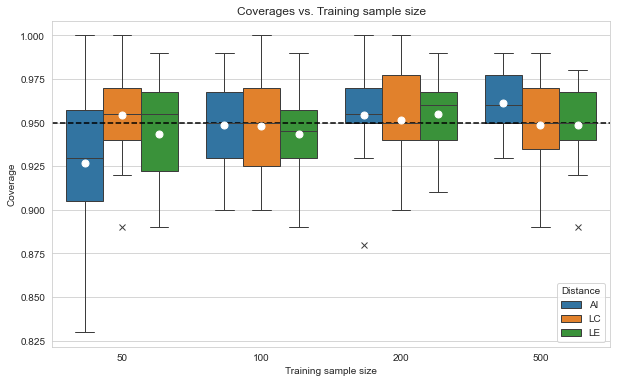

In [32]:
# Plot coverages vs. training sample size
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(data=coverage_df_combined, x='train_size', y='coverage', hue='distance', palette=sns.color_palette(),
            flierprops={"marker": "x"}, dodge=True, showmeans = True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'white','markersize':'7'})

plt.legend(title='Distance')
plt.title('Coverages vs. Training sample size')
plt.xlabel('Training sample size')
plt.ylabel('Coverage')
plt.axhline(y=1-sign_level, color='black', linestyle='dashed')
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/2849022827.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=coverage_df, x='df', y='coverage', hue='train_size', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


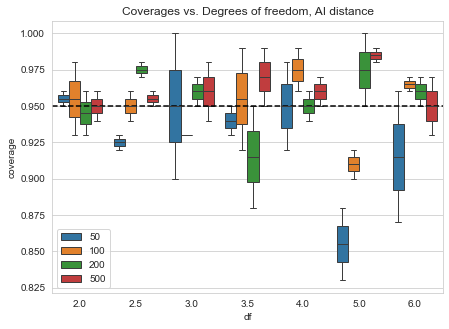

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/2849022827.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=coverage_df, x='df', y='coverage', hue='train_size', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


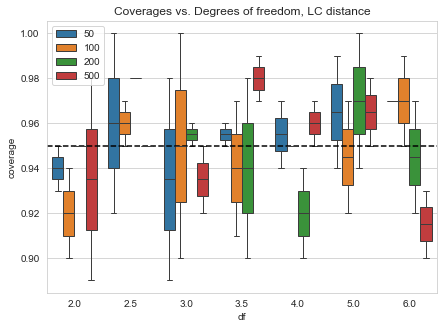

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/2849022827.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=coverage_df, x='df', y='coverage', hue='train_size', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


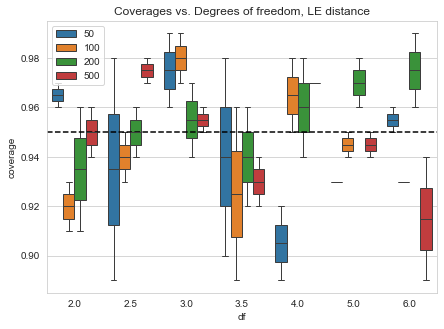

In [33]:
for dist in ['AI', 'LC', 'LE']:
    plt.figure(figsize=(7,5))
    if dist == 'LC':
        coverage_df = coverage_df_LC
    elif dist == 'AI':
        coverage_df = coverage_df_AI
    else:
        coverage_df = coverage_df_LE
    sns.boxplot(data=coverage_df, x='df', y='coverage', hue='train_size', palette=sns.color_palette(),
                flierprops={'marker':'x'}, dodge=True)
    plt.title(f'Coverages vs. Degrees of freedom, {dist} distance')
    plt.axhline(y=1-sign_level, color='black', linestyle='dashed')
    plt.legend()
    plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/2657605371.py:13: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=coverage_df, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


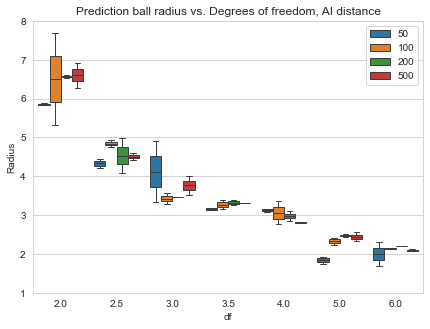

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/2657605371.py:13: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=coverage_df, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


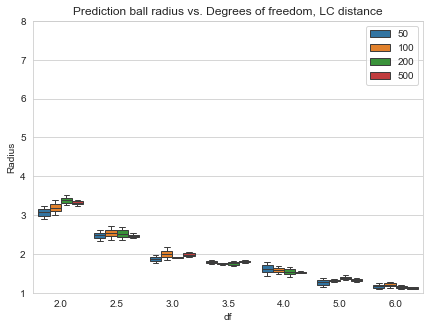

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/2657605371.py:13: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=coverage_df, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


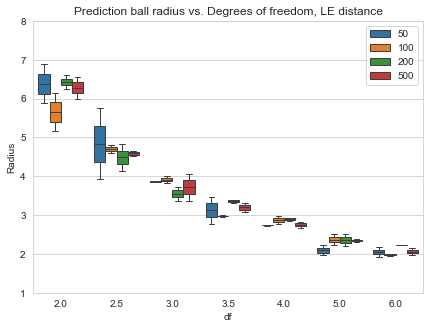

In [34]:
# NOTE: What is interesting is to see the decaay in the radius as df increases, but 
# comparing the radius between the distances is not informative since the magnitudes depend
# on the distance used

for dist in ['AI', 'LC', 'LE']:
    plt.figure(figsize=(7,5))
    if dist == 'LC':
        coverage_df = coverage_df_LC
    elif dist == 'AI':
        coverage_df = coverage_df_AI
    else:
        coverage_df = coverage_df_LE
    sns.boxplot(data=coverage_df, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
                flierprops={'marker':'x'}, dodge=True)
    plt.title(f'Prediction ball radius vs. Degrees of freedom, {dist} distance')
    plt.ylabel('Radius')
    plt.ylim(1, 8)
    plt.legend()
    plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_13487/745852613.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=coverage_df, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


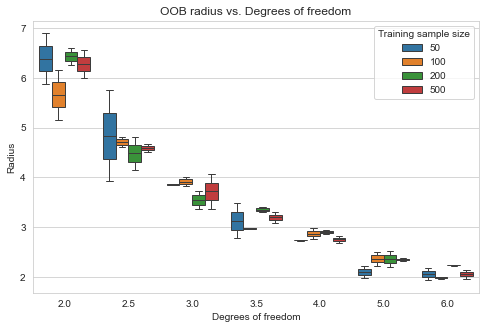

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(data=coverage_df, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
            flierprops={'marker':'x'})
plt.title('OOB radius vs. Degrees of freedom')
plt.xlabel('Degrees of freedom')
plt.ylabel('Radius')
plt.legend(title='Training sample size')#.remove()
plt.show()

# Plot prediction balls

Obtain a smaller dataset with the columns selected conveniently to observe the impact of the parameters in the shape of prediction balls.

In [36]:
new_coverage_df = coverage_df_combined[(coverage_df_combined['sample_index'] == 15) & 
                              (coverage_df_combined['df'].isin([2, 6])) & 
                              (coverage_df_combined['train_size'].isin([50, 200]))]
new_coverage_df = new_coverage_df.sort_values(by=['sample_index', 'train_size', 'df', 'distance']).reset_index(drop=True)
new_coverage_df.head()

,sample_index,train_size,df,kappa,coverage,OOB_quantile,OOB_errors,test_data,test_predictions,distance
0,15,50,2.0,0.500000,0.96,5.881230,"[3.2785288367858287, 2.841199087450472, 1.9014...","[[[1.5146326328622768, 3.2374881696200224], [3...","[[[0.7449946044045846, 0.928267763624804], [0....",AI
1,15,50,2.0,0.500000,0.95,2.909585,"[2.1968403472933353, 3.7383212624344444, 1.959...","[[-0.475326739446335, -1.069410791938342, -0.9...","[[0.5541024072221651, -0.4154005774048079, -0....",LC
2,15,50,2.0,0.500000,0.97,5.875634,"[3.4057834781417218, 3.760485904462724, 1.1961...","[[[0.41366945000112115, -0.6127642636183583], ...","[[[1.265414688174784, -0.48472982054404057], [...",LE
3,15,50,6.0,0.166667,0.96,2.301558,"[0.8441141401177925, 0.772619071118493, 1.2864...","[[[0.5105660153710795, -0.13690313999041148], ...","[[[0.9475652709357552, 0.16099095817807635], [...",AI
4,15,50,6.0,0.166667,0.97,1.242104,"[0.8054993010336803, 0.1918429645490971, 0.345...","[[-0.37673170605779976, -0.052850490078882005,...","[[-0.2389731715363304, -0.40851905884028095, 0...",LC


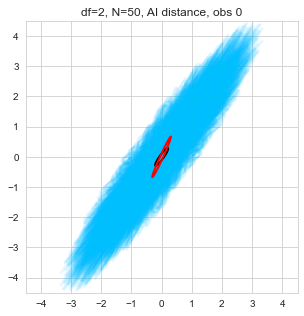

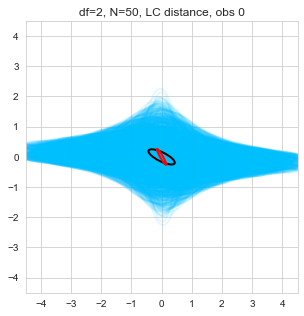

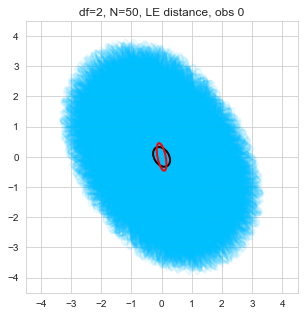

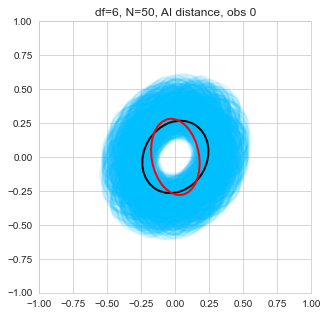

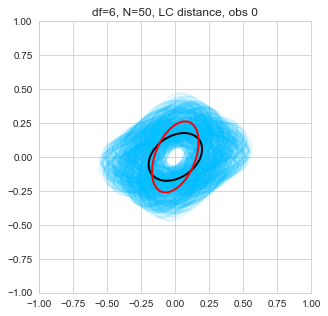

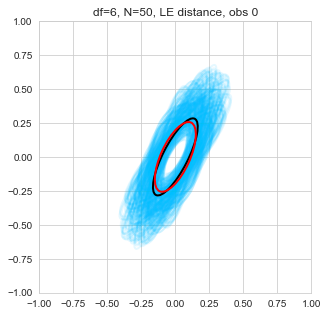

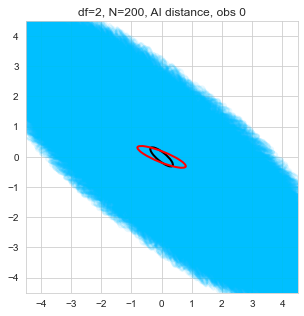

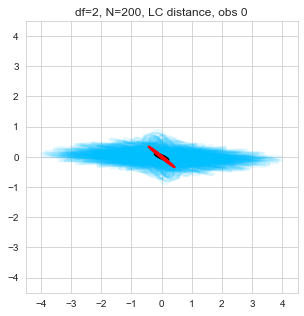

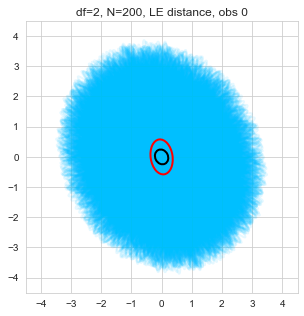

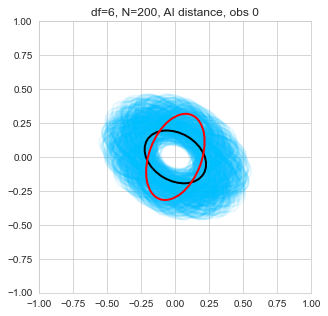

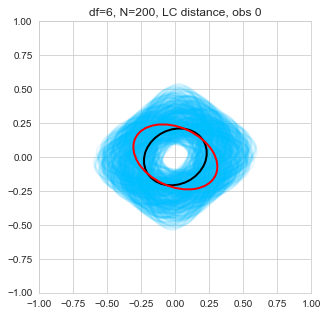

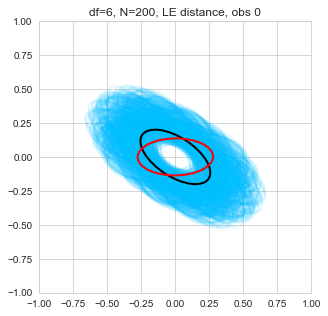

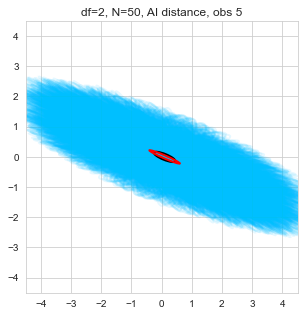

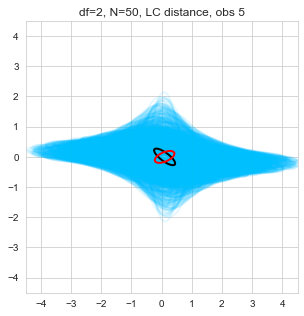

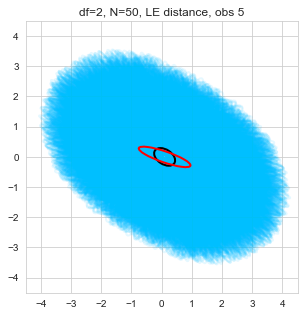

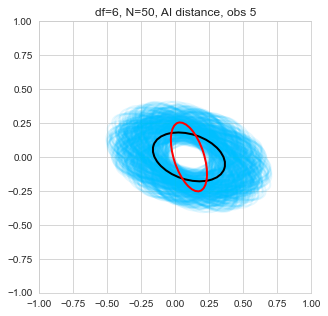

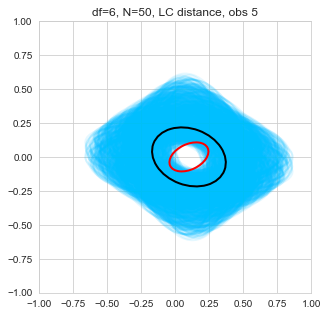

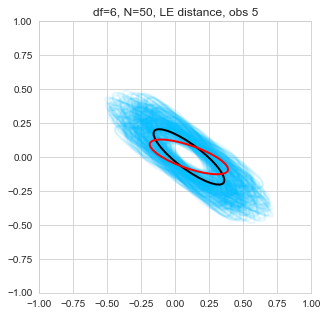

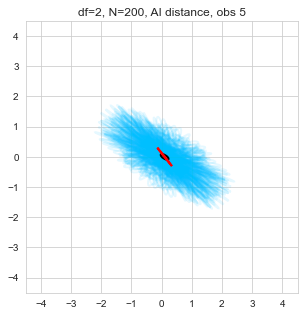

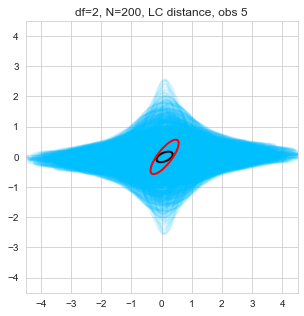

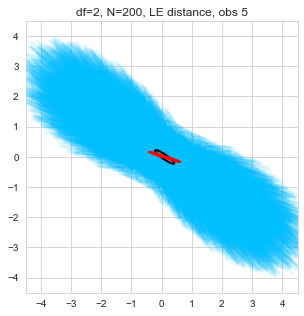

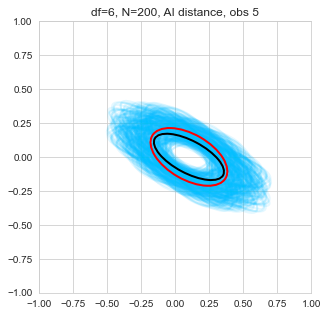

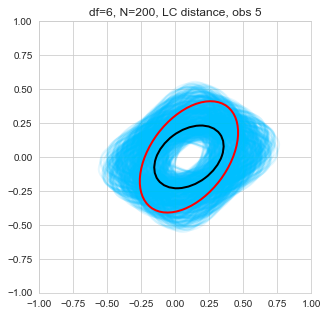

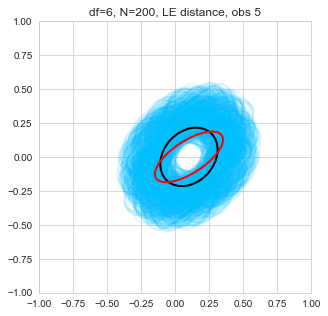

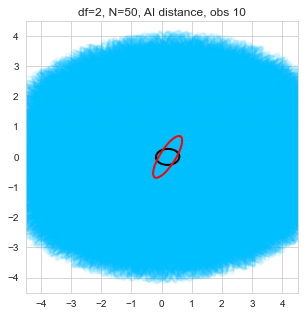

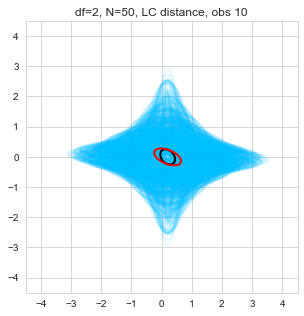

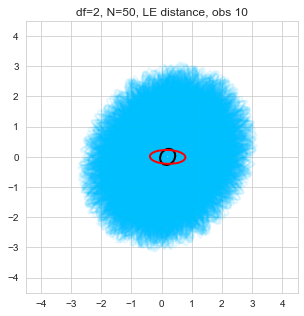

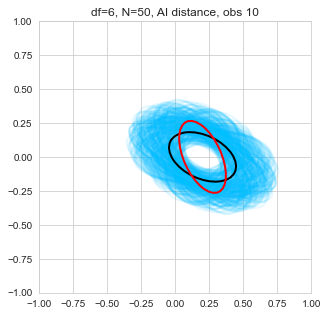

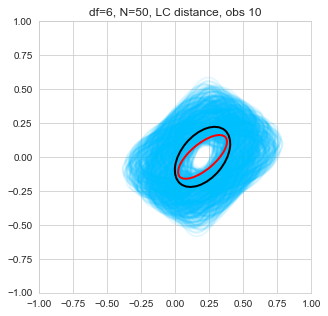

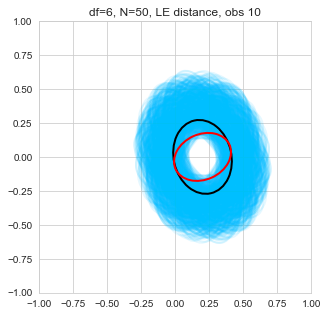

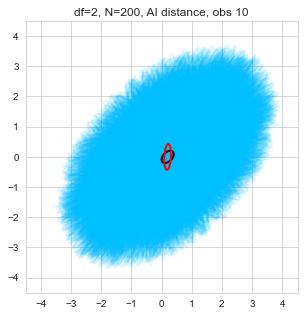

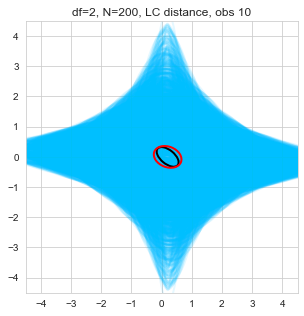

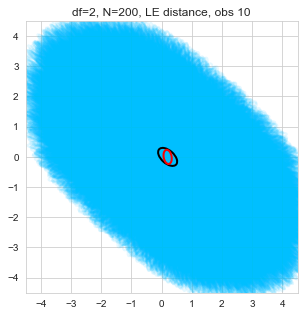

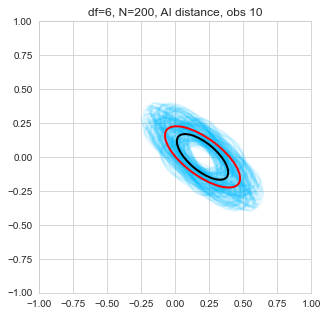

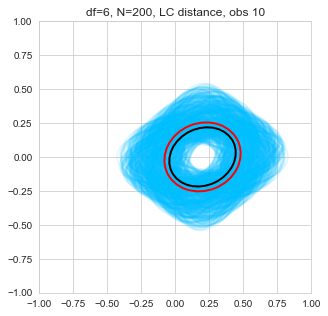

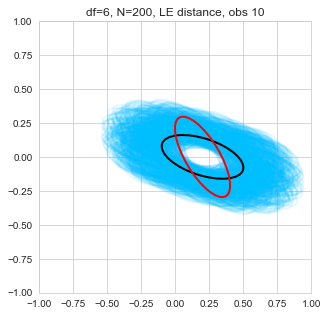

In [37]:
# Plot OOB prediction balls
alpha=0.1
new_coverage_df
for ind in [0,5,10]:
    for row_idx in range(new_coverage_df.shape[0]):
        row = new_coverage_df.loc[row_idx]
        if row['distance'] == 'AI':
            M = CustomAffineInvariant(dim=2)
        elif row['distance'] == 'LC':
            M = LogCholesky(dim=2)
        else:
            M = CustomLogEuclidean(dim=2)
        oob_errors = row['OOB_errors']
        test_data = row['test_data']
        test_predictions = row['test_predictions']
        Ralpha=np.percentile(oob_errors, (1-alpha)*100)
        fig, ax=plt.subplots(figsize=(5, 5))
        if row['df'] == 2:
            plt.xlim(-4.5,4.5)
            plt.ylim(-4.5,4.5)
            limits_unif = 35
        else:
            plt.xlim(-1,1)
            plt.ylim(-1,1)
            limits_unif = 10
        plot_OOB_balls_SPD(dist = row['distance'], predictions = test_predictions, reference=test_data, indices_to_plot= [ind],
                            Ralpha=Ralpha, ax=ax, scale_factor=1/2, MC_samples=100000, xy_factor=50, alpha = alpha, limits_unif=limits_unif)
        ax.set_aspect('equal', 'box')

        plt.title(f'df={int(row["df"])}, N={row["train_size"]}, {row["distance"]} distance, obs {ind}')
        plt.show()